## Imports

In [163]:
import math
import pandas as pd
from keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import missingno as msno
import matplotlib.pyplot as plt


# ETL

In [164]:
df = pd.read_csv('junteDatos.csv')

<Axes: >

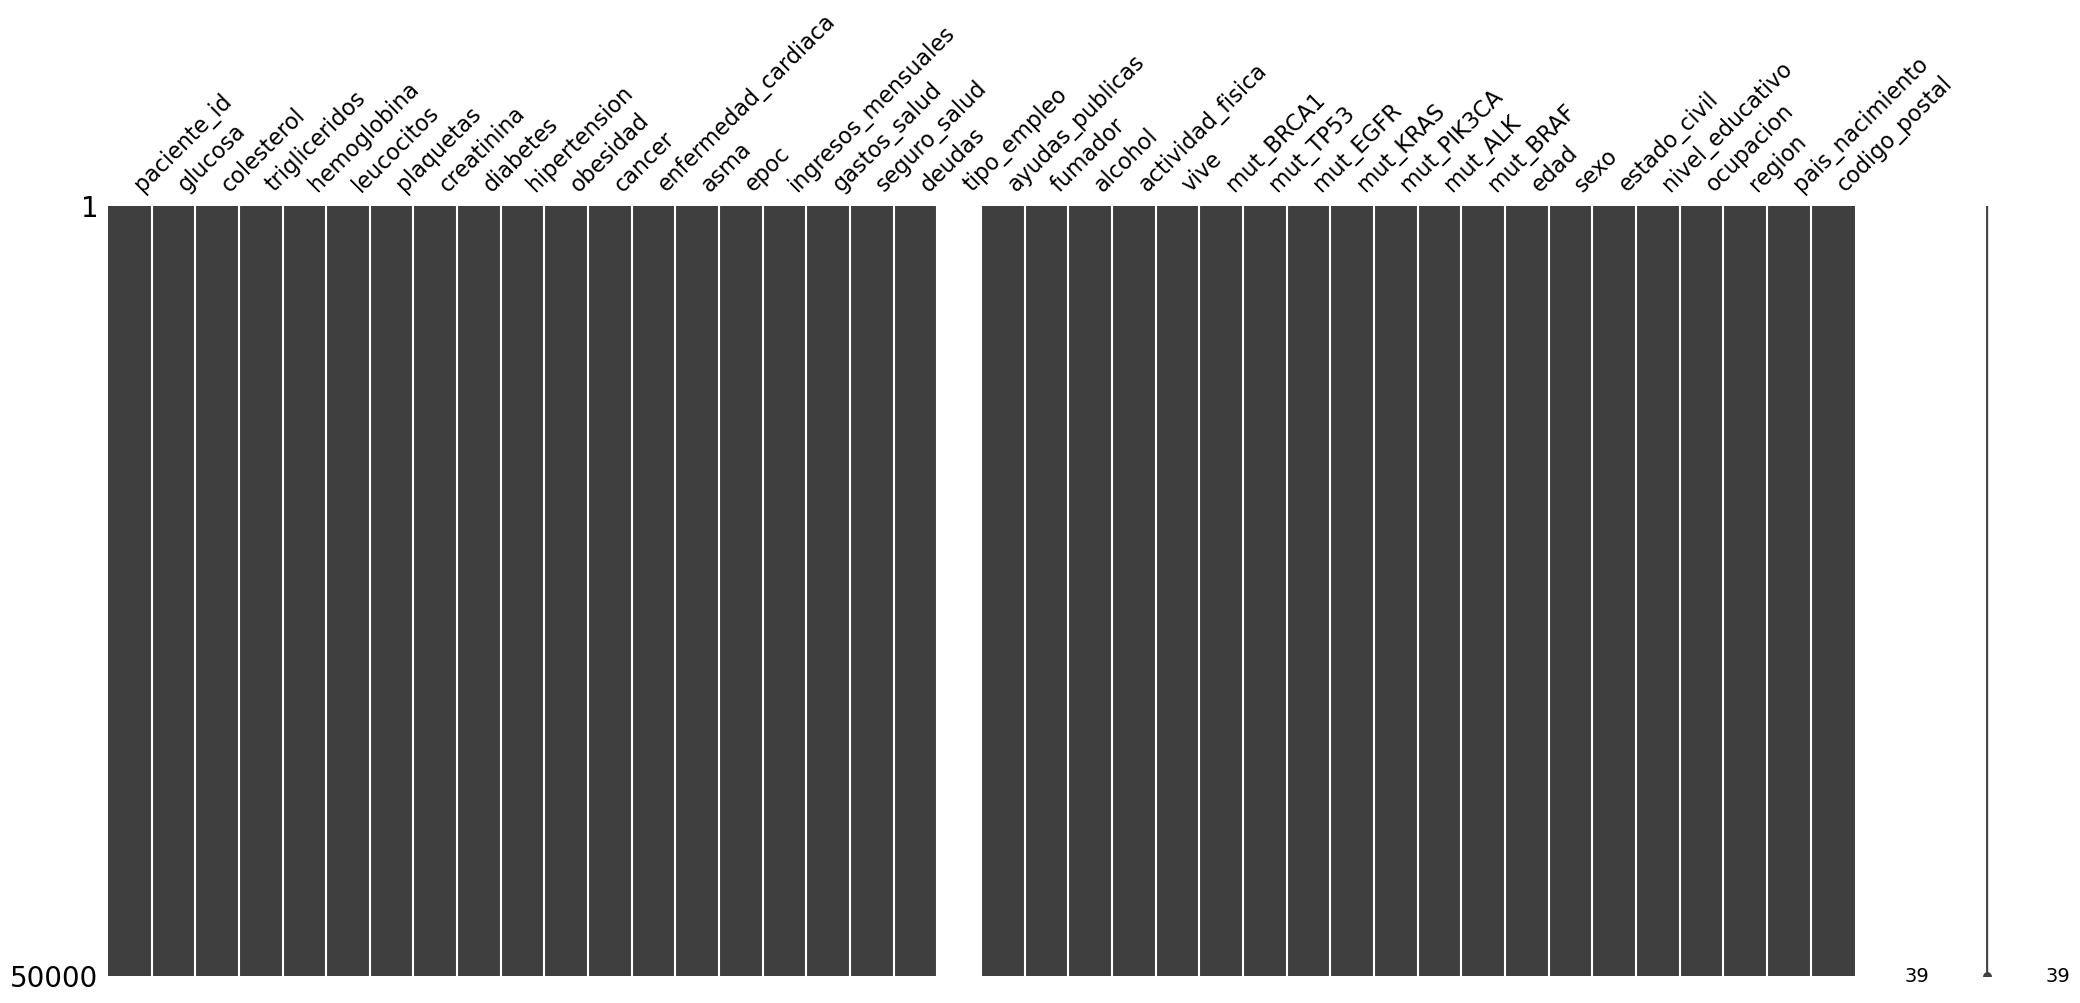

In [165]:
# missingno para ver datos faltantes
msno.matrix(df)

In [166]:
# sacamos la columna tipo_empleo

df.drop(columns=['tipo_empleo'], inplace=True)

In [167]:
# Mostrar las primeras filas para entender la estructura
display(df.head())

# Mostrar información general: tipos de datos y conteo de valores no nulos
print(df.info())

,paciente_id,glucosa,colesterol,trigliceridos,hemoglobina,leucocitos,plaquetas,creatinina,diabetes,hipertension,...,mut_ALK,mut_BRAF,edad,sexo,estado_civil,nivel_educativo,ocupacion,region,pais_nacimiento,codigo_postal
0,P1000000,108.81,226.16,161.07,13.24,6.12,258.09,0.97,1,1,...,0,1,69,F,Viudo,Secundaria,Empleado,Centro,Indonesia,98471
1,P1000001,74.23,148.89,110.77,13.68,6.97,278.32,0.85,0,0,...,0,1,32,M,Soltero,Universitaria,Autónomo,Sur,Brazil,23903
2,P1000002,88.61,177.53,91.93,12.76,7.54,245.35,1.59,0,0,...,0,0,89,M,Viudo,Primaria,Desempleado,Norte,Saint Pierre and Miquelon,20094
3,P1000003,90.92,203.97,121.79,12.95,8.56,245.11,1.26,1,0,...,0,0,78,M,Viudo,Secundaria,Autónomo,Centro,Indonesia,55575
4,P1000004,69.17,154.33,78.34,12.34,8.20,234.44,0.88,0,0,...,0,0,38,F,Soltero,Posgrado,Autónomo,Norte,Chile,20826


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   paciente_id          50000 non-null  object 
 1   glucosa              50000 non-null  float64
 2   colesterol           50000 non-null  float64
 3   trigliceridos        50000 non-null  float64
 4   hemoglobina          50000 non-null  float64
 5   leucocitos           50000 non-null  float64
 6   plaquetas            50000 non-null  float64
 7   creatinina           50000 non-null  float64
 8   diabetes             50000 non-null  int64  
 9   hipertension         50000 non-null  int64  
 10  obesidad             50000 non-null  int64  
 11  cancer               50000 non-null  int64  
 12  enfermedad_cardiaca  50000 non-null  int64  
 13  asma                 50000 non-null  int64  
 14  epoc                 50000 non-null  int64  
 15  ingresos_mensuales   50000 non-null 

In [168]:
def map_to_continent(country):
    """
    Mapea el nombre de un país (o territorio) a su continente correspondiente.
    Si el país no está en ninguna lista, devuelve 'Other'.
    """
    asia = {
        'Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan',
        'Brunei Darussalam', 'Cambodia', 'China', 'Cyprus', 'Georgia', 'Hong Kong',
        'India', "Indonesia", 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan',
        'Kuwait', "Lao People's Democratic Republic", 'Lebanon', 'Malaysia', 'Maldives',
        'Macao', 'Mongolia', 'Myanmar', 'Nepal', 'North Macedonia', 'Oman',
        'Pakistan', 'Philippines', 'Qatar', 'Saudi Arabia', 'Singapore', 'Sri Lanka',
        'Syrian Arab Republic', 'Taiwan', 'Thailand', 'Timor-Leste', 'Turkmenistan',
        'United Arab Emirates', 'Uzbekistan', 'Yemen'
    }
    europe = {
        'Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
        'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland',
        'France', 'Germany', 'Gibraltar', 'Greece', 'Guernsey', 'Holy See (Vatican City State)',
        'Hungary', 'Iceland', 'Ireland', 'Isle of Man', 'Italy', 'Jersey', 'Latvia',
        'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Monaco', 'Montenegro',
        'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania',
        'Russian Federation', 'San Marino', 'Serbia', 'Slovakia (Slovak Republic)', 'Slovenia',
        'Spain', 'Svalbard & Jan Mayen Islands', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom'
    }
    africa = {
        'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde',
        'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Djibouti',
        'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon',
        'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast', "Cote d'Ivoire",
        'Kenya', 'Lesotho', 'Liberia', 'Libyan Arab Jamahiriya', 'Madagascar', 'Malawi',
        'Mali', 'Mauritania', 'Mauritius', 'Mayotte', 'Morocco', 'Mozambique',
        'Namibia', 'Niger', 'Nigeria', 'Reunion', 'Rwanda', 'Saint Helena',
        'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia',
        'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda',
        'Western Sahara', 'Zambia', 'Zimbabwe'
    }
    north_america = {
        'Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Bermuda', 'Canada',
        'Costa Rica', 'Cayman Islands', 'Cuba', 'Dominica', 'Dominican Republic',
        'El Salvador', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Martinique',
        'Mexico', 'Montserrat', 'Netherlands Antilles', 'Nicaragua', 'Panama',
        'Puerto Rico', 'Saint Kitts and Nevis', 'Saint Lucia',
        'Saint Martin', 'Saint Vincent and the Grenadines',
        'Trinidad and Tobago', 'Turks and Caicos Islands', 'United States of America',
        'United States Virgin Islands'
    }
    south_america = {
        'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador',
        'French Guiana', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'
    }
    oceania = {
        'American Samoa', 'Australia', 'Christmas Island', 'Cocos (Keeling) Islands',
        'Cook Islands', 'Fiji', 'French Polynesia', 'Guam', 'Kiribati', 'Marshall Islands',
        'Micronesia', 'Nauru', 'New Caledonia', 'Niue', 'Norfolk Island', 'Palau',
        'Papua New Guinea', 'Pitcairn Islands', 'Samoa', 'Solomon Islands', 'Tokelau',
        'Tonga', 'Tuvalu', 'Vanuatu', 'Wallis and Futuna'
    }
    antarctica = {
        'Antarctica (the territory South of 60 deg S)',
        'Bouvet Island (Bouvetoya)',
        'Heard Island and McDonald Islands'
    }

    # Normalizamos algunos nombres alternativos
    _normalize = {
        "Cote d'Ivoire": "Ivory Coast",
        "Russian Federation": "Russian Federation",
        "Syrian Arab Republic": "Syrian Arab Republic",
        "Bosnia and Herzegovina": "Bosnia and Herzegovina"
    }
    key = _normalize.get(country, country)

    if key in asia:
        return 'Asia'
    if key in europe:
        return 'Europe'
    if key in africa:
        return 'Africa'
    if key in north_america:
        return 'North America'
    if key in south_america:
        return 'South America'
    if key in oceania:
        return 'Oceania'
    if key in antarctica:
        return 'Antarctica'
    return 'Other'

In [169]:
# quiero ver todos los paises distintos

paises = df['pais_nacimiento'].unique()

print(paises)

['Indonesia' 'Brazil' 'Saint Pierre and Miquelon' 'Chile' 'Cuba'
 'American Samoa' 'Montenegro' 'Cameroon' 'Barbados' 'Slovenia'
 'Greenland' 'China' 'Somalia' 'Senegal' 'Korea' 'Palau' 'Swaziland'
 'Antigua and Barbuda' 'Holy See (Vatican City State)' 'Netherlands'
 'Equatorial Guinea' 'Samoa' 'Montserrat' 'San Marino' 'Cayman Islands'
 'Malta' 'Tuvalu' 'Benin' 'United States of America' 'Bahamas'
 'Cape Verde' 'Kazakhstan' 'French Guiana' 'Switzerland' "Cote d'Ivoire"
 'Azerbaijan' 'Timor-Leste' 'Gibraltar' 'Vanuatu' 'Malawi'
 'Saint Vincent and the Grenadines' 'Algeria' 'France' 'Honduras'
 'Nigeria' 'Turkmenistan' 'Isle of Man' 'Fiji' 'Singapore' 'Kenya'
 'Sweden' 'Qatar' 'Ethiopia' 'Panama' 'Gambia' 'Liechtenstein' 'Finland'
 'Serbia' 'Kuwait' 'Iceland' 'Syrian Arab Republic' 'Australia' 'Greece'
 'British Indian Ocean Territory (Chagos Archipelago)'
 'Trinidad and Tobago' 'Guadeloupe' 'Dominica' 'Sierra Leone'
 'Afghanistan' 'Canada' 'Israel' 'French Polynesia' 'Mongolia' 'Congo'

In [170]:
col_flags = {
    # Identificador único (sin uso para el modelo)
    'paciente_id': {
        'include': False,
        'encoding': None,
        'mapping': None
    },

    # Biomarcadores continuos — normalizar más adelante
    'glucosa': {
        'include': True,
        'encoding': 'numeric',
        'mapping': None
    },
    'colesterol': {
        'include': True,
        'encoding': 'numeric',
        'mapping': None
    },
    'trigliceridos': {
        'include': True,
        'encoding': 'numeric',
        'mapping': None
    },
    'hemoglobina': {
        'include': True,
        'encoding': 'numeric',
        'mapping': None
    },
    'leucocitos': {
        'include': True,
        'encoding': 'numeric',
        'mapping': None
    },
    'plaquetas': {
        'include': True,
        'encoding': 'numeric',
        'mapping': None
    },
    'creatinina': {
        'include': True,
        'encoding': 'numeric',
        'mapping': None
    },
    'cancer': {
        'include': True,
        'encoding': 'binary',
        'mapping': None
    },

    # Historial clínico binario 0/1 — ya numérico, usar tal cual
    'diabetes': {
        'include': True,
        'encoding': 'binary',
        'mapping': None
    },
    'hipertension': {
        'include': True,
        'encoding': 'binary',
        'mapping': None
    },
    'obesidad': {
        'include': True,
        'encoding': 'binary',
        'mapping': None
    },

    # Actividad física — ordinal: Baja < Moderada < Alta
    'actividad_fisica': {
        'include': True,
        'encoding': 'ordinal',
        'mapping': {'Baja': 0, 'Moderada': 1, 'Alta': 2}
    },

    # Sexo — binario
    'sexo': {
        'include': True,
        'encoding': 'ordinal',
        'mapping': {'F': 1, 'M': 0}
    },

    # Estado civil — nominal con pocos niveles → one-hot
    'estado_civil': {
        'include': True,
        'encoding': 'onehot',
        'mapping': None
    },

    # Nivel educativo — ordinal: Primaria < Secundaria < Universitaria < Posgrado
    'nivel_educativo': {
        'include': True,
        'encoding': 'ordinal',
        'mapping': {
            'Primaria': 0,
            'Secundaria': 1,
            'Universitaria': 2,
            'Posgrado': 3
        }
    },

    # Ocupación — nominal → one-hot
    'ocupacion': {
        'include': True,
        'encoding': 'onehot',
        'mapping': None
    },

    # Región (Centro, Sur, Norte, Oeste, Este) — ordinal o one-hot (no orden real) → one-hot
    'region': {
        'include': True,
        'encoding': 'onehot',
        'mapping': None
    },

    # País de nacimiento — muchos niveles → agrupar por continente (o income group) y luego one-hot
    'pais_nacimiento': {
        'include': False,
        'encoding': 'onehot',
        'mapping': 'map_to_continent'  # p.ej. Asia, Europa, América, África, Oceanía
    },

    # Código postal — no aporta mucho, podemos excluirlo
    'codigo_postal': {
        'include': False,
        'encoding': None,
        'mapping': None
    }
}

In [171]:
# Asumimos df y col_flags ya definidos
df_1 = pd.DataFrame()

# Primero, las variables incluidas
for col, props in col_flags.items():
    if not props['include']:
        continue

    enc = props['encoding']
    mapping = props['mapping']

    if enc == 'numeric' or enc == 'binary':
        # Copiamos la columna tal cual
        df_1[col] = df[col]
        
    elif enc == 'ordinal':
        # Mapeo directo a valores enteros
        df_1[col] = df[col].map(mapping)

    elif enc == 'onehot':
        # One-hot encoding con pandas
        dummies = pd.get_dummies(df[col], prefix=col)
        df_1 = pd.concat([df_1, dummies], axis=1)

    elif enc == 'grouped_onehot':
        # Ejemplo: mapeo de país a continente
        df['__group__'] = df[col].map(lambda x: map_to_continent(x))
        dummies = pd.get_dummies(df['__group__'], prefix=col)
        df_1 = pd.concat([df_1, dummies], axis=1)
        df.drop(columns='__group__', inplace=True)

    else:
        raise ValueError(f"Encoding no reconocido para {col}: {enc}")


## Train and test

In [172]:
# 1) Define aquí las fracciones que quieras para test y validation
test_frac = 0.2       # 20% de todo para test
val_frac  = 0.2       # 20% de todo para validation
# El resto (1 - test_frac - val_frac) acabará en train (aquí 60%)

# 2) Primero separamos el test set:
#    - train_val contendrá el (1 - test_frac) restante
train_val, test = train_test_split(
    df_1,
    test_size=test_frac,
    random_state=42,    # semilla para reproducibilidad
    shuffle=True        # barajamos antes de partir
)

# 3) Calculamos qué proporción de train_val corresponde a validation:
#    val_frac es % sobre el dataset completo,
#    pero aquí necesitamos la parte relativa a train_val
val_size_rel = val_frac / (1 - test_frac)

# 4) Ahora separamos train_val en train y validation
train, val = train_test_split(
    train_val,
    test_size=val_size_rel,
    random_state=42,
    shuffle=True
)

# 5) Comprobamos tamaños
print(f"Total:    {len(df_1)} filas")
print(f"Train:    {len(train)} filas ({len(train)/len(df_1):.1%})")
print(f"Valida.:  {len(val)} filas ({len(val)  /len(df_1):.1%})")
print(f"Test:     {len(test)} filas ({len(test) /len(df_1):.1%})")

Total:    50000 filas
Train:    30000 filas (60.0%)
Valida.:  10000 filas (20.0%)
Test:     10000 filas (20.0%)


In [173]:
# show len of columns in train 
print(len(train.columns))

27


In [174]:
response = 'cancer'

# 1) Separamos X e y para train, val y test
x_train = train.drop(columns=[response])
y_train = train[response]

x_val   = val.drop(columns=[response])
y_val   = val[response]

x_test  = test.drop(columns=[response])
y_test  = test[response]

# 2) Identificamos las columnas no binarias (p.ej. dtype numérico y >2 valores únicos)
numeric_cols = [
    col for col in x_train.columns
    if pd.api.types.is_numeric_dtype(x_train[col]) and x_train[col].nunique() > 2
]

# 3) Calculamos media y desviación solo sobre train
means = {}
stds  = {}
for col in numeric_cols:
    means[col] = x_train[col].mean()
    stds[col]  = x_train[col].std()

# 4) Normalizamos train, val y test con un bucle for
for df in (x_train, x_val, x_test):
    for col in numeric_cols:
        df[col] = (df[col] - means[col]) / stds[col]

### Normalizing

In [175]:
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

# PRIMER MODELO DE PRUEBA

In [176]:
hidden_units = 10     # how many neurons in the hidden layer
activation = 'relu'   # activation function for hidden layer
l2 = 0.01             # regularization - how much we penalize large parameter values
learning_rate = 0.01  # how big our steps are in gradient descent
epochs = 5            # how many epochs to train for
batch_size = 16       # how many samples to use for each gradient descent update

In [177]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=26,
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

/Users/frankllonch/anaconda3/envs/cancer/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [178]:
# # train the parameters
# history = model.fit(x_train, y_train, epochs=10, batch_size=batch_size)

# # evaluate accuracy
# train_acc = model.evaluate(x_train, y_train, batch_size=32)[1]
# test_acc = model.evaluate(x_test, y_test, batch_size=32)[1]
# print('Training accuracy: %s' % train_acc)
# print('Testing accuracy: %s' % test_acc)

# losses = history.history['loss']
# plt.plot(range(len(losses)), losses, 'r')
# plt.show()

### entrenamos 20 veces para encontrar average accuracy

In [179]:
# def train_and_evaluate(model, x_train, y_train, x_test, y_test, n=20):
#     train_accs = []
#     test_accs = []
#     with tqdm(total=n) as progress_bar:
#         for _ in range(n):
#             model.fit(
#                 x_train, 
#                 y_train, 
#                 epochs=epochs, 
#                 batch_size=batch_size,
#                 verbose=False)
#             train_accs.append(model.evaluate(x_train, y_train, batch_size=32, verbose=False)[1])
#             test_accs.append(model.evaluate(x_test, y_test, batch_size=32, verbose=False)[1])
#             progress_bar.update()
#     print('Avgerage Training Accuracy: %s' % np.average(train_accs))
#     print('Avgerage Testing Accuracy: %s' % np.average(test_accs))
#     return train_accs, test_accs

In [180]:
# _, test_accs = train_and_evaluate(model, x_train, y_train, x_test, y_test)

In [181]:
# plt.hist(test_accs)
# plt.title('Histogram of Testing Accuracies')
# plt.xlabel('Accuracy')
# plt.ylabel('Frequency')
# plt.show()

### Baseline

In [182]:
# print('Min: %s' % np.min(test_accs))
# print('Max: %s' % np.max(test_accs))

# Buscamos parametros optimos para batir al baseline

## Opcion 1 keras

In [183]:
# import tensorflow as tf
# import keras_tuner as kt
# from tensorflow.keras import models, layers, regularizers, optimizers

# # 1) Definimos la función build_model que KerasTuner usará para crear y compilar modelos
# def build_model(hp):
#     """
#     hp: objeto HyperParameters que nos permite definir el espacio de búsqueda.
#     Debemos usar hp.Int, hp.Float, hp.Choice, etc. para declarar rangos/valores.
#     """
#     model = models.Sequential()
    
#     # 1.1) capa de entrada + primer hidden:
#     #   - units: número de neuronas, entero entre 16 y 128 paso 16
#     #   - activation: función de activación, elección entre 'relu' y 'tanh'
#     #   - kernel_regularizer: L2, intensidad entre 1e-4 y 1e-2 (muestreo logarítmico)
#     model.add(
#         layers.Dense(
#             units=hp.Int('units', min_value=16, max_value=128, step=16),
#             activation=hp.Choice('activation', ['relu', 'tanh']),
#             kernel_regularizer=regularizers.l2(
#                 hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='log')
#             ),
#             input_shape=(x_train.shape[1],)  # número de features dinámico
#         )
#     )
    
#     # 1.2) capa de salida: usando sigmoid para output binario
#     model.add(layers.Dense(1, activation='sigmoid'))
    
#     # 1.3) compilamos:
#     #   - optimizer: Adam con tasa de aprendizaje entre 1e-4 y 1e-2
#     #   - loss: entropía cruzada binaria
#     #   - métricas: accuracy
#     model.compile(
#         optimizer=optimizers.Adam(
#             learning_rate=hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
#         ),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
    
#     return model


# # 2) Configuramos el tuner: Hyperband es una estrategia que combina
# #    exploración amplia con eliminaciones tempranas de configuraciones pobres.
# tuner = kt.Hyperband(
#     build_model,                        # función que construye el modelo
#     objective='val_accuracy',           # criterio para comparar modelos
#     max_epochs=30,                      # número máximo de epochs por modelo
#     factor=3,                           # factor de reducción de Hyperband
#     directory='my_tuner_dir',           # carpeta donde guarda logs/checkpoints
#     project_name='cancer_pred_tuner'    # nombre del subdirectorio del proyecto
# )

# # 3) Callback de early stopping para no malgastar epochs si no mejora validación
# stop_early = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',                 # monitoreamos la pérdida de validación
#     patience=5,                         # si no mejora en 5 epochs, paramos
#     restore_best_weights=True           # recuperamos los pesos del mejor epoch
# )

# # 4) Lanzamos la búsqueda
# tuner.search(
#     x_train,                            # datos de entrenamiento
#     y_train,                            # targets de entrenamiento
#     validation_split=0.2,               # 20% de train reservado como validación
#     epochs=50,                          # máximo 50 epochs (pero puede parar antes)
#     callbacks=[stop_early],             # early stopping
#     verbose=1                           # mostrar progreso
# )

# # 5) Tras la búsqueda, obtenemos los 3 mejores sets de hiperparámetros
# best_hps = tuner.get_best_hyperparameters(num_trials=3)

# # 6) Imprimimos los valores óptimos encontrados
# for i, hp in enumerate(best_hps, start=1):
#     print(f"Trial {i}:")
#     print(f"  units: {hp.get('units')}")
#     print(f"  activation: {hp.get('activation')}")
#     print(f"  l2_reg: {hp.get('l2_reg'):.1e}")
#     print(f"  learning_rate: {hp.get('lr'):.1e}")
#     print()

In [184]:
# import keras_tuner as kt
# from tensorflow.keras import models, layers, regularizers, optimizers

# def build_model(hp):
#     model = models.Sequential()
#     # calculamos input_dim dinámico
#     inp_dim = x_train.shape[1]
#     # nº de unidades en la capa oculta
#     units = hp.Int('units', min_value=16, max_value=128, step=16)
#     model.add(layers.Dense(
#         units=units,
#         activation=hp.Choice('activation', ['relu', 'tanh']),
#         kernel_regularizer=regularizers.l2(hp.Float('l2_reg', 1e-4, 1e-2, sampling='log')),
#         input_shape=(inp_dim,)
#     ))
#     model.add(layers.Dense(1, activation='sigmoid'))

#     model.compile(
#         optimizer=optimizers.Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=30,
#     factor=3,
#     directory='my_tuner',
#     project_name='cancer_pred'
# )

# # Callback de early stopping
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# tuner.search(
#     x_train, y_train,
#     validation_split=0.2,
#     epochs=50,
#     callbacks=[stop_early]
# )

# # Resultados
# best_hps = tuner.get_best_hyperparameters(3)
# for hp in best_hps:
#     print(hp.values)

# BEST MODEL

Trial 90 Complete [00h 00m 16s]
val_accuracy: 0.8889999985694885

Best val_accuracy So Far: 0.8889999985694885
Total elapsed time: 00h 07m 23s
{'units': 48, 'activation': 'relu', 'l2_reg': 0.0018308334177090633, 'lr': 0.0019517956376273492, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
{'units': 32, 'activation': 'relu', 'l2_reg': 0.002360255858604888, 'lr': 0.002804488546812046, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
{'units': 128, 'activation': 'relu', 'l2_reg': 0.008955123965905103, 'lr': 0.0003244843025329892, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}


## Opcion 2 Optuna

In [185]:
# import optuna
# import tensorflow as tf
# from tensorflow.keras import models, layers, regularizers, optimizers, backend as K

# # 1) Función objetivo que Optuna va a optimizar
# def objective(trial):
#     """
#     trial: objeto de Optuna que sugiere valores para cada hiperparámetro.
#     Debemos devolver una métrica a maximizar (aquí validación acc).
#     """
#     # 1.1) Optimizamos 4 hiperparámetros:
#     n_units    = trial.suggest_int('n_units',      16, 128, step=16)
#     lr         = trial.suggest_loguniform('lr',     1e-4, 1e-2)
#     l2_reg     = trial.suggest_loguniform('l2_reg', 1e-4, 1e-2)
#     activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    
#     # 1.2) Limpiamos sesión previa (libera grafo, variables…)
#     K.clear_session()
    
#     # 1.3) Construimos el modelo con esos parámetros
#     model = models.Sequential([
#         layers.Dense(
#             units=n_units,
#             activation=activation,
#             kernel_regularizer=regularizers.l2(l2_reg),
#             input_shape=(x_train.shape[1],)
#         ),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=optimizers.Adam(learning_rate=lr),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
    
#     # 1.4) Entrenamos con validación interna y early stopping
#     history = model.fit(
#         x_train, y_train,
#         validation_split=0.2,                  # 20% de train como validación
#         epochs=30,                             # tope de 30 epochs
#         batch_size=32,
#         verbose=0,                             # sin imprimir cada epoch
#         callbacks=[
#             tf.keras.callbacks.EarlyStopping(
#                 monitor='val_loss',
#                 patience=5,
#                 restore_best_weights=True
#             )
#         ]
#     )
    
#     # 1.5) Extraemos la mejor métrica de validación lograda
#     val_accs = history.history['val_accuracy']
#     best_val_acc = max(val_accs)
    
#     return best_val_acc  # Optuna busca maximizar esto

# # 2) Creamos el estudio y decimos que queremos maximizar
# study = optuna.create_study(direction='maximize')

# # 3) Lanzamos 50 trials (intentos) de búsqueda bayesiana
# study.optimize(objective, n_trials=50)

# # 4) Mostramos resultados finales
# print("== Best trial ==")
# print(f"  Validation Accuracy: {study.best_value:.4f}")
# print("  Params:")
# for key, val in study.best_params.items():
#     print(f"    {key}: {val}")

# Validation

In [186]:
# 1. Get the single best HyperParameters object
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# 2. Rebuild a fresh model using exactly those hyper-parameters
#    If you used the same build_model(hp) function:
final_model = build_model(best_hp)

# 3. Train it on your train set, validating on your validation set.
#    Here you can use more epochs, since these HPs proved promising.
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = final_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,              # or whatever max you like
    batch_size=best_hp.get('tuner/bracket') if False else 32,
    callbacks=[stop_early],
    verbose=1
)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.8832 - loss: 0.4143 - val_accuracy: 0.8847 - val_loss: 0.3787
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.8829 - loss: 0.3516 - val_accuracy: 0.8847 - val_loss: 0.3824
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.8813 - loss: 0.3565 - val_accuracy: 0.8847 - val_loss: 0.3880
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.8818 - loss: 0.3553 - val_accuracy: 0.8847 - val_loss: 0.3775
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - accuracy: 0.8851 - loss: 0.3453 - val_accuracy: 0.8847 - val_loss: 0.3814
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.8822 - loss: 0.3535 - val_accuracy: 0.8847 - val_loss: 0.3785
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.8859 - loss: 0.3472 - val_accuracy: 0.8847 - val_loss: 0.3850
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.8846 - loss: 0.3484 - 

In [187]:
# 4. Evaluate on the validation set
val_loss, val_acc = final_model.evaluate(x_val, y_val, verbose=0)
print(f'Final validation accuracy: {val_acc:.4f}')

Final validation accuracy: 0.8847


In [190]:
# leer juntedatos
x_v_id = pd.read_csv('x_v_id.csv')

In [191]:
# create x_val_1 , adding paciente_id back to the df

x_val_1 = pd.DataFrame(x_val, columns=x_val.columns)
x_val_1['paciente_id'] = x_v_id['paciente_id'].values


In [196]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 1) Obtén las probabilidades y conviértelas a etiquetas (umbral 0.5)
y_pred_prob = final_model.predict(x_val)       # shape (n_samples, 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()    # 0 o 1

# 2) Matriz de confusión y reporte
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}\n")

print("Classification Report:")
print(classification_report(y_val, y_pred, digits=4))

# 3) Crear un DataFrame con predicción y verdad para filtrar
results = x_val.copy()
results['y_true']  = y_val.values
results['y_pred']  = y_pred

# 4) Pacientes mal clasificados
misclassified = results[results['y_true'] != results['y_pred']]
print(f"\nTotal mal clasificados: {len(misclassified)}")
display(misclassified.head())


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
True Negatives:  8847
False Positives: 0
False Negatives: 1153
True Positives:  0

Classification Report:
              precision    recall  f1-score   support

           0     0.8847    1.0000    0.9388      8847
           1     0.0000    0.0000    0.0000      1153

    accuracy                         0.8847     10000
   macro avg     0.4424    0.5000    0.4694     10000
weighted avg     0.7827    0.8847    0.8306     10000


Total mal clasificados: 1153


/Users/frankllonch/anaconda3/envs/cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/frankllonch/anaconda3/envs/cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/frankllonch/anaconda3/envs/cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

,glucosa,colesterol,trigliceridos,hemoglobina,leucocitos,plaquetas,creatinina,diabetes,hipertension,obesidad,...,ocupacion_Desempleado,ocupacion_Empleado,ocupacion_Jubilado,region_Centro,region_Este,region_Norte,region_Oeste,region_Sur,y_true,y_pred
41933,-0.552305,0.847338,1.308442,-0.825340,-0.677124,0.230311,-0.467671,0,0,0,...,False,False,True,False,False,True,False,False,1,0
27206,0.828924,0.006022,1.276843,-1.226989,-0.302067,0.175108,-0.421038,0,0,0,...,True,False,False,False,False,False,False,True,1,0
48370,0.896980,-0.404958,1.299148,-0.283115,0.931673,-0.056242,0.838043,1,0,1,...,True,False,False,False,False,False,False,True,1,0
40633,-0.812928,0.320957,0.901373,-2.251193,0.319738,-0.208802,-0.840732,0,1,0,...,False,False,True,True,False,False,False,False,1,0
43822,-1.881717,-0.699791,-1.539557,2.347683,1.681787,-0.750541,-0.467671,0,0,0,...,False,False,True,False,False,True,False,False,1,0
